In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import os 
#Set the path according to your situation
image_dir = os.getcwd() + '/drive/MyDrive/Colab Notebooks/PytorchNeuralStyleTransfer-master/Images/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch import Tensor

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict
from pylab import *

from typing import Type, Any, Callable, Union, List, Optional, cast
from collections import OrderedDict 

# Load CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-h9ncjr3b
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-h9ncjr3b


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.0+cu113


In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
# Select device to work on.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import clip
model_vit, preprocess_vit = clip.load('ViT-B/16', device = device)

In [ ]:
preprocess_vit

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f094b0510e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
model_vit = model_vit.visual

In [ ]:
model_vit

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise

# Load images

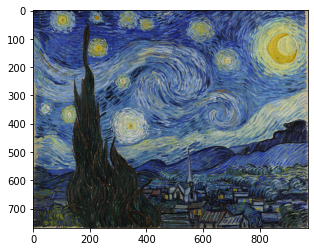

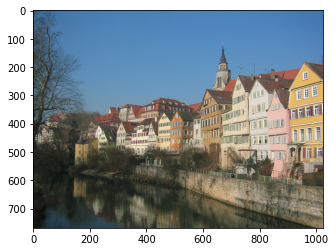

In [ ]:
##### load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]

for img in imgs:
  imshow(img);show()

# Preprocess the image data

In [ ]:
prep = transforms.Compose([transforms.Resize(size=224, max_size=None, antialias=None),
                           transforms.CenterCrop(size=(224, 224)),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul(255)),
                          ])

postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [ ]:
##### load images, ordered as [style_image, content_image]
imgs_torch = [prep(img) for img in imgs]

if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = Variable(content_image.data.clone(), requires_grad=True)

# Define Gram matrix

In [ ]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        #b = batch size, p = patch nums(197), d = dimension of linear embedding(768)
        b, p, d = input.size()
        F = input
        G = torch.bmm(F, F.transpose(1,2)) 
        #G.div_(d)
        #G = torch.multiply(G, d)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        #loss = nn.MSELoss()
        #output = loss(input, target)
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

# Extract activation outputs of each attention block using ***Forward hook***

In [ ]:
#create dic to store activation outputs
style_activations = {}
content_activations = {}
opt_activations = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    style_activations[name] = output.detach()
    content_activations[name] = output.detach()
    opt_activations[name] = output
  return hook

In [ ]:
h1 = model_vit.conv1.register_forward_hook(getActivation('conv1'))
h2 = model_vit.ln_pre.register_forward_hook(getActivation('ln_pre'))
b0 = model_vit.transformer.resblocks[0].register_forward_hook(getActivation('b0'))
b1 = model_vit.transformer.resblocks[1].register_forward_hook(getActivation('b1'))
b2 = model_vit.transformer.resblocks[2].register_forward_hook(getActivation('b2'))
b3 = model_vit.transformer.resblocks[3].register_forward_hook(getActivation('b3'))
b4 = model_vit.transformer.resblocks[4].register_forward_hook(getActivation('b4'))
b5 = model_vit.transformer.resblocks[5].register_forward_hook(getActivation('b5'))
b6 = model_vit.transformer.resblocks[6].register_forward_hook(getActivation('b6'))
b7 = model_vit.transformer.resblocks[7].register_forward_hook(getActivation('b7'))
b8 = model_vit.transformer.resblocks[8].register_forward_hook(getActivation('b8'))
b9 = model_vit.transformer.resblocks[9].register_forward_hook(getActivation('b9'))
b10 = model_vit.transformer.resblocks[10].register_forward_hook(getActivation('b10'))
b11 = model_vit.transformer.resblocks[11].register_forward_hook(getActivation('b11'))

In [ ]:
test = model_vit(style_image)
test = style_activations['b0'].permute(1, 0, 2)[:, 1:, :]
test

tensor([[[-0.1921,  0.2901, -0.0501,  ...,  0.0840, -0.0917, -0.3172],
         [ 0.0290,  0.4809, -0.1604,  ..., -0.0747,  0.0411, -0.4785],
         [-0.1155,  0.2268,  0.0297,  ..., -0.0022,  0.0500, -0.3711],
         ...,
         [-0.0242,  0.3286, -0.1148,  ..., -0.0289,  0.0764, -0.3810],
         [-0.2237,  0.3501, -0.1360,  ..., -0.0100,  0.0926, -0.4354],
         [-0.0900,  0.0692,  0.1024,  ...,  0.0071,  0.0937, -0.3863]]])

In [ ]:
result = GramMatrix()(test)
result

tensor([[[18.2048,  5.5271,  8.1325,  ...,  6.1755,  5.5011,  6.3372],
         [ 5.5271, 36.9933,  8.7524,  ..., 17.2383, 23.1401, 21.8756],
         [ 8.1325,  8.7524, 20.9145,  ...,  9.5938,  9.6302,  8.4753],
         ...,
         [ 6.1755, 17.2383,  9.5938,  ..., 27.2379, 17.3946, 15.6185],
         [ 5.5011, 23.1401,  9.6302,  ..., 17.3946, 37.4895, 22.9069],
         [ 6.3372, 21.8756,  8.4753,  ..., 15.6185, 22.9069, 34.8430]]])

# Define layers, loss functions, weights and compute optimization targets

In [ ]:
#define layers, loss functions, weights and compute optimization targets

#style layers: b0, b1, b2, b3, b4 / content layer: b3
style_layers = ['b0', 'b3', 'b5', 'b7', 'b10']
content_layers = ['b5']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

#weights settings
style_weights = [1e3/n**2 for n in [768, 768, 768, 768, 768]]
content_weights = [1e0]
weights = style_weights + content_weights

#get activation outputs
style_result = model_vit(style_image)
style_activations_list = []
for i, (k, v) in enumerate(style_activations.items()):
  if k in style_layers:
    style_activations_list.append(v)

content_result = model_vit(content_image)
content_activations_list = []
for i, (k, v) in enumerate(content_activations.items()):
  if k in content_layers:
    content_activations_list.append(v)

#permute the tensor shape and delete cls token, in order to compute gram matrix
for i in range(len(style_activations_list)):
  style_activations_list[i] = style_activations_list[i].permute(1, 0, 2)[:, 1:, :]


for i in range(len(content_activations_list)):
  content_activations_list[i] = content_activations_list[i].permute(1, 0, 2)[:, 1:, :]

#output style and content activations' shape
print('Activations of style image:')
for i in range(len(style_activations_list)):
  print(f"Layer {i}:", style_activations_list[i].shape)

print('Activations of content image:')
for i in range(len(content_activations_list)):
  print(f"Layer {i}:", content_activations_list[i].shape)

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in style_activations_list]
content_targets = [A.detach() for A in content_activations_list]
targets = style_targets + content_targets

Activations of style image:
Layer 0: torch.Size([1, 196, 768])
Layer 1: torch.Size([1, 196, 768])
Layer 2: torch.Size([1, 196, 768])
Layer 3: torch.Size([1, 196, 768])
Layer 4: torch.Size([1, 196, 768])
Activations of content image:
Layer 0: torch.Size([1, 196, 768])


In [ ]:
#opt_img = Variable(content_image.data.clone(), requires_grad=True)
out_img_result = model_vit(opt_img)
opt_activations_list = []
for i, (k, v) in enumerate(opt_activations.items()):
  if k in style_layers:
    opt_activations_list.append(v)
for i, (k, v) in enumerate(opt_activations.items()):
  if k in content_layers:
    opt_activations_list.append(v)

for i in range(len(opt_activations_list)):
  opt_activations_list[i] = opt_activations_list[i].permute(1, 0, 2)[:, 1:, :]

layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(opt_activations_list)]
layer_losses

[tensor(0.2821, grad_fn=<MulBackward0>),
 tensor(0.4794, grad_fn=<MulBackward0>),
 tensor(0.1524, grad_fn=<MulBackward0>),
 tensor(0.0802, grad_fn=<MulBackward0>),
 tensor(0.7556, grad_fn=<MulBackward0>),
 tensor(0., grad_fn=<MulBackward0>)]

Iteration: 50, loss: 1.734820
Iteration: 100, loss: 1.716284
Iteration: 150, loss: 1.693168
Iteration: 200, loss: 1.665116


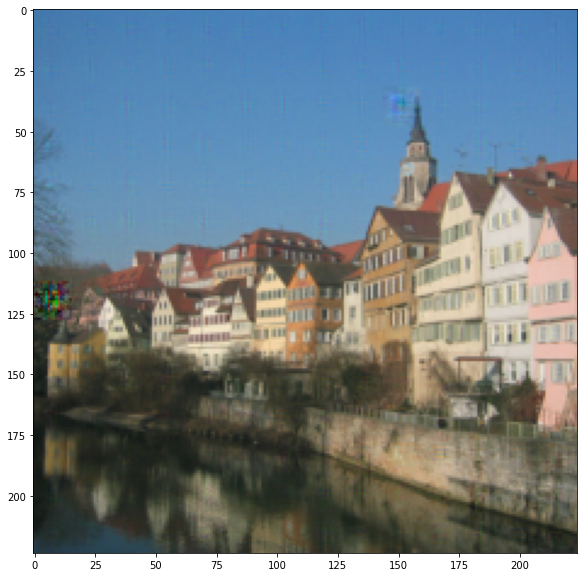

In [ ]:
#run style transfer
max_iter =200
show_iter = 50

optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out_img_result = model_vit(opt_img)
        opt_activations_list = []
        for i, (k, v) in enumerate(opt_activations.items()):
          if k in style_layers:
            opt_activations_list.append(v)
        for i, (k, v) in enumerate(opt_activations.items()):
          if k in content_layers:
            opt_activations_list.append(v)

        for i in range(len(opt_activations_list)):
          opt_activations_list[i] = opt_activations_list[i].permute(1, 0, 2)[:, 1:, :]

        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(opt_activations_list)]
        
        loss = 0
        for layer_loss in layer_losses:
          loss = loss + layer_loss
        loss.backward()
        n_iter[0]+=1
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)